<h2> Testing out some shared plotting utilities for the Chlorine data </h2>

The plots in each individual experimental campas for our own internal use.

Cl2 LabJack: Cl2 reading minus zero (mV)
The plots here are meant as drafts of 'nicer' plots for papers, presentations, etc.
We'll try to develop some tools to streamline their generation and reduce copy-pasted code.

In [37]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../_shared_packages')
import cl2_utilities as cl2_utils
import importlib

In [39]:
# Global definitions to standardize plots in this notebook

# This is where we'd override the matplotlib fonts, if we wanted to

# Store line colors, styles, and markdown labels so we can change them easily and don't need to repeat them.
default_properties = {'CH4':{'color':'C0','marker':'o','linestyle':'--','text':'-$\Delta$CH$_4$'},
                      'Cl2':{'color':'g','marker':'o','linestyle':'--','text':'-$\Delta$Cl$_2$'},
                      'CO2':{'color':'xkcd:violet','marker':'o','linestyle':'--','text':'$\Delta$CO$_2$'},
                      'CO':{'color':'xkcd:teal','marker':'o','linestyle':'--','text':'$\Delta$CO',},
                      'CH2O':{'color':'xkcd:navy','marker':'o','linestyle':'--','text':'$\Delta$CH$_2$O'},
                      'C1 Sum':{'color':'xkcd:pink','marker':'o','linestyle':':','text':'$\Delta$CO+$\Delta$CO$_2$+$\Delta$CH$_2$O'},
                      'Cl* Efficiency':{'color':'xkcd:olive','marker':'o','linestyle':':','text':'[Placeholder]'},
                      }

# Grab the constants stored in the Cl2 utilities
importlib.reload(cl2_utils)
cl2_experiment_constants = cl2_utils.cl2_experiment_constants()

In [7]:
# Load all the experimental data from the intermediate files. See the readme for where these files came from.
bypass_data_929 = pd.read_csv("../_exported_data/bypasses_09-29_cl2_campaign_after_mfc_zero.csv")
conversion_data_929 = pd.read_csv("../_exported_data/conversions_09-29_cl2_campaign_after_mfc_zero.csv")
bypass_data_924 = pd.read_csv("../_exported_data/bypasses_09-24_cl2_sweeps_no_cofeed.csv")
conversion_data_924 = pd.read_csv("../_exported_data/conversions_09-24_cl2_sweeps_no_cofeed.csv")
all_bypass_data = pd.concat([bypass_data_924,bypass_data_929],axis=0,ignore_index=True).reindex()
all_conversion_data = pd.concat([conversion_data_924,conversion_data_929],axis=0,ignore_index=True).reindex()

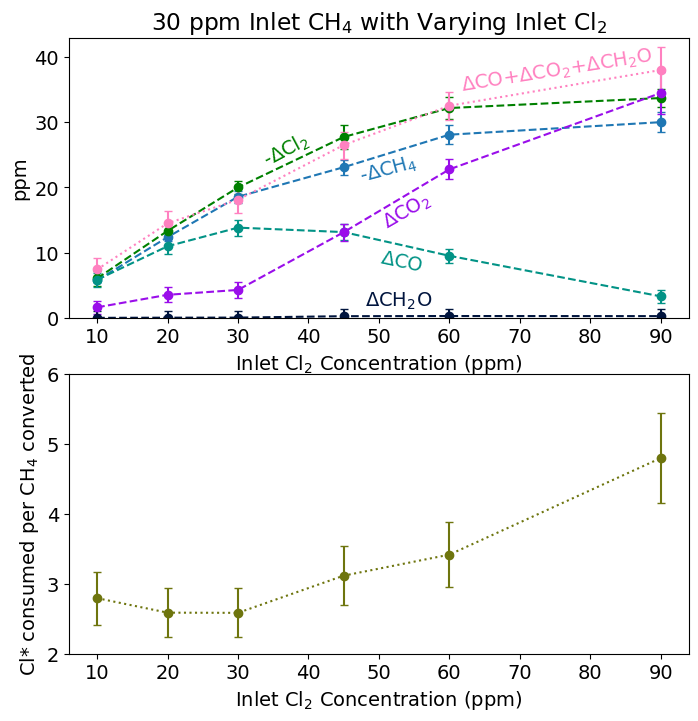

In [47]:
importlib.reload(cl2_utils)
""" Data Extraction """

# Select data from only the the experiments we want
exps = ["09-28-24 Vary Cl2 (20-90 ppm) at Fixed CH4","09-19-24 Vary Cl2 (5-30 ppm) at Fixed CH4"]
bypass_data = all_bypass_data[all_bypass_data["experiment_name"].isin(exps)]
conversion_data = all_conversion_data[all_conversion_data["experiment_name"].isin(exps)]
conversion_data = conversion_data[(conversion_data['experiment_name']=="09-19-24 Vary Cl2 (5-30 ppm) at Fixed CH4") | # Use exp. with 100 ppm Cl2 tank for Cl2 5-30 ppm and exp. with 1000 ppm Cl2 tank for 45-90 ppm.
                                  (conversion_data['Cl2 LabJack: Cl2 reading minus zero (mV) baseline']>40)] # Proxy for >=45 ppm is a Cl2 measurement of more than 85mV
conversion_data=conversion_data.sort_values(by='Cl2 LabJack: Cl2 reading minus zero (mV) baseline',ascending=True)

# Extract the values and 95% CI from the CH4 conversion data
((ch4_conversions,ch4_95_ci),) = cl2_utils.extract_spectrometer_data_from_conversions(conversion_data,
            fields=['Selected: CH4 (ppm)'], percent_accuracy_95 = cl2_experiment_constants.picarro_percent_accuracy_95, absolute_accuracy_95 = cl2_experiment_constants.picarro_absolute_accuracy_95)

# Extract the values and 95% CI from the Cl2 conversion data
cl2_tank_ppms = np.array([1000 if b>40 else 100 for b in conversion_data['Cl2 LabJack: Cl2 reading minus zero (mV) baseline']]) # Only Cl2 conc's 45 and over used the 1000 ppm tank
(cl2_baseline, cl2_conversions, cl2_conversion_95_ci) = cl2_utils.extract_cl2_data_from_conversions(conversion_data,bypass_data,cl2_tank_ppms,cl2_experiment_constants.cl2_mfc_sccm_accuracy_95,cl2_experiment_constants.cl2_node_absolute_accuracy_95)
inlet_cl2 = cl2_baseline

# Extract the means and 95% CI's for each gas in each bypass period
fields = ['FTIR: CO2 (ppm)','FTIR: CO (ppm)','FTIR: CH2O (ppm)']
((co2,co2_95_ci),(co,co_95_ci),(ch2o,ch2o_95_ci)) = cl2_utils.extract_spectrometer_data_from_bypass(conversion_data,bypass_data,fields,percent_accuracy_95=5,absolute_accuracy_95=1)

# Get the means and 95% CI for the sum of all of them
co_co2_ch2o_sum = co2+co+ch2o
co_co2_ch2o_95_ci = 2*np.sqrt((0.5*co2_95_ci)**2 + (0.5*co_95_ci)**2 + (0.5*ch2o_95_ci)**2)

""" Plotting and Cosmetics """
# Plot options
use_error_bars = True
show_products = True

# Setup subplots
plt.rcParams.update({'font.size': 14})
(fig,(ax1,ax2)) = plt.subplots(nrows=2,figsize=(8,8),sharex=True)

# Make the first plot
cl2_utils.do_error_bar(ax1,default_properties,'CH4',inlet_cl2,ch4_conversions,(ch4_95_ci if use_error_bars else None))
cl2_utils.do_error_bar(ax1,default_properties,'Cl2',inlet_cl2,cl2_conversions,(cl2_conversion_95_ci if use_error_bars else None))
if show_products:
    cl2_utils.do_error_bar(ax1,default_properties,'CO',inlet_cl2,co,(co_95_ci if use_error_bars else None))
    cl2_utils.do_error_bar(ax1,default_properties,'CO2',inlet_cl2,co2,(co2_95_ci if use_error_bars else None))
    cl2_utils.do_error_bar(ax1,default_properties,'CH2O',inlet_cl2,ch2o,(ch2o_95_ci if use_error_bars else None))
    cl2_utils.do_error_bar(ax1,default_properties,'C1 Sum',inlet_cl2,co_co2_ch2o_sum,(co_co2_ch2o_95_ci if use_error_bars else None))
ax1.set_ylabel("ppm")
ax1.set_xlabel("Inlet Cl$_2$ Concentration (ppm)")
ax1.set_ylim(0,43)
#ax1.legend(fontsize=12,loc='lower left',bbox_to_anchor=(1,0.38))
ax1.xaxis.set_tick_params(labelbottom=True)
# Make the second plot
(cl_budget,cl_budget_95_ci) = cl2_utils.get_cl_radical_budget(inlet_cl2)
cl_per_ch4 = cl_budget / ch4_conversions
cl2_per_ch4_95_ci = cl2_utils.get_95_ci_of_ratio(cl_budget,cl_budget_95_ci,ch4_conversions,ch4_95_ci)
#cl2_per_ch4_95_ci = cl_budget_95_ci/ch4_conversions

cl2_utils.do_error_bar(ax2,default_properties,'Cl* Efficiency',inlet_cl2,cl_per_ch4,(cl2_per_ch4_95_ci if use_error_bars else None))
ax2.set_ylabel("Cl* consumed per CH$_4$ converted")
ax2.set_xlabel("Inlet Cl$_2$ Concentration (ppm)")
ax2.xaxis.set_tick_params(labelbottom=True)
ax2.set_ylim(2,6)

# Labeling
labels = (('CH4',47,20,15),
          ('CO2',50,13,30),
          ('CO',50,6.5,-12),
          ('CH2O',48,1,0),
          ('C1 Sum',61.5,34,9),
          ('Cl2',33,22.5,28))
cl2_utils.label_lines(ax1,default_properties,labels)

ax1.set_title("30 ppm Inlet CH$_4$ with Varying Inlet Cl$_2$")
plt.show()